In [8]:
import pandas as pd
import numpy as np                    
import matplotlib.pyplot as plt

# Load your cleaned datasets from the 'cleaned-data' dataset
reviews = pd.read_csv("/kaggle/input/datasett/AirlineScrappedReview_Cleaned.csv")
bookings = pd.read_csv("/kaggle/input/mydata/Bookings_Cleaned.csv")

print("✅ Datasets loaded successfully!")
print("Reviews shape:", reviews.shape)
print("Bookings shape:", bookings.shape)

# Quick preview
display(reviews.head(3))
display(bookings.head(3))


✅ Datasets loaded successfully!
Reviews shape: (3575, 18)
Bookings shape: (50002, 13)


,Passanger_Name,Flying_Date,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
0,Paige Boet,June 2023,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,NaN,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
1,S Layne,March 2023,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,NaN,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,..."
2,E Lanewoski,NaN,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,NaN,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye"


,route,flight_hour,flight_day,trip_type,sales_channel,num_passengers,purchase_lead,length_of_stay,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,AKLHGH,6,Tue,RoundTrip,Internet,1,21,12,0,0,0,7.21,1
1,AKLDEL,7,Sat,RoundTrip,Internet,2,262,19,1,0,0,5.52,0
2,AKLDEL,3,Sat,RoundTrip,Internet,1,112,20,0,0,0,5.52,0


In [9]:
# Build a clean text field
reviews["Review_title"]   = reviews.get("Review_title", "").fillna("").astype(str)
reviews["Review_content"] = reviews.get("Review_content", "").fillna("").astype(str)
reviews["Review_text"] = (reviews["Review_title"] + ". " + reviews["Review_content"])\
    .str.replace(r"\s+", " ", regex=True).str.strip()

# Add VADER sentiment only if missing
if "Sentiment_score" not in reviews.columns or "Sentiment_label" not in reviews.columns:
    import nltk
    from nltk.sentiment import SentimentIntensityAnalyzer
    try:
        nltk.data.find("sentiment/vader_lexicon.zip")
    except LookupError:
        nltk.download("vader_lexicon")
    sia = SentimentIntensityAnalyzer()

    reviews["Sentiment_score"] = reviews["Review_text"].apply(
        lambda t: sia.polarity_scores(t)["compound"] if isinstance(t, str) else np.nan
    )
    def to_label(c):
        if pd.isna(c): return np.nan
        if c >= 0.05:  return "Positive"
        if c <= -0.05: return "Negative"
        return "Neutral"
    reviews["Sentiment_label"] = reviews["Sentiment_score"].apply(to_label)

# Satisfaction target (per spec)
if "satisfaction" not in reviews.columns and "Rating" in reviews.columns:
    reviews["satisfaction"] = (reviews["Rating"] >= 5).astype(int)

# Harmonize traveler type column name
# Auto-detect traveler type column
trav_col = None
for col in ["Traveler_Type", "Traveller_Type"]:
    if col in reviews.columns:
        trav_col = col
        break
if trav_col is None:
    raise ValueError("Expected 'Traveler_Type' or 'Traveller_Type' in reviews.")
print("Traveler column used:", trav_col)



Traveler column used: Traveller_Type


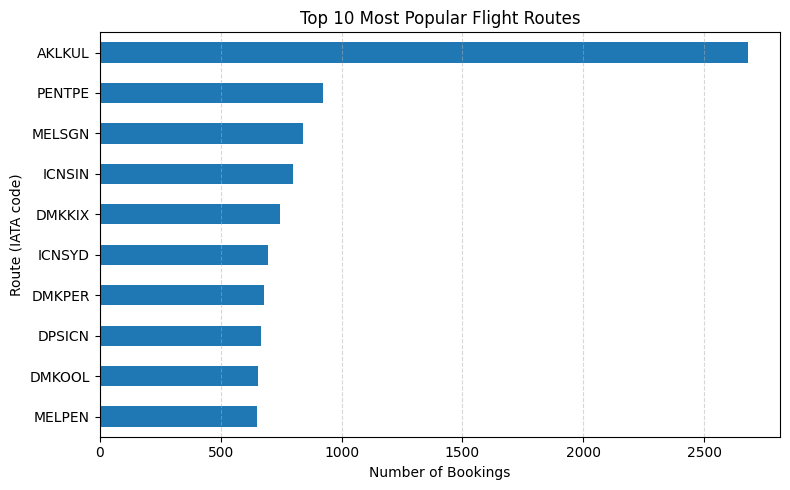

,Route,Booking_Count
0,MELPEN,649
1,DMKOOL,655
2,DPSICN,666
3,DMKPER,679
4,ICNSYD,695
5,DMKKIX,744
6,ICNSIN,801
7,MELSGN,842
8,PENTPE,924
9,AKLKUL,2680


In [10]:
top_routes = (bookings["route"].value_counts().head(10).sort_values(ascending=True))

plt.figure(figsize=(8,5))
top_routes.plot(kind="barh")
plt.title("Top 10 Most Popular Flight Routes")
plt.xlabel("Number of Bookings"); plt.ylabel("Route (IATA code)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()  # ensures labels and titles don't overlap
plt.show()

top_routes_df = top_routes.reset_index()
top_routes_df.columns = ["Route", "Booking_Count"]
display(top_routes_df)


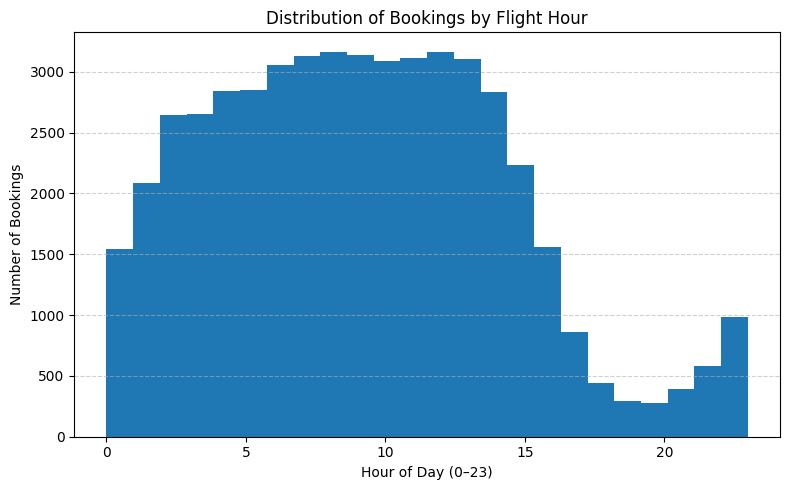

In [11]:
plt.figure(figsize=(8,5))
(bookings["flight_hour"].dropna().astype(int)).plot(kind="hist", bins=24)
plt.title("Distribution of Bookings by Flight Hour")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Bookings")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()  # ensures labels and titles don't overlap
plt.show()


Top 5 traveler-type & class combos (avg rating):


,Traveller_Type,Class,Rating
19,Unknown,First Class,7.127273
14,Solo Leisure,First Class,6.627907
6,Couple Leisure,First Class,5.983607
17,Unknown,Business Class,5.982935
20,Unknown,Premium Economy,5.919540



Bottom 5 combos:


,Traveller_Type,Class,Rating
11,Family Leisure,Premium Economy,3.600000
0,Business,Business Class,3.510791
1,Business,Economy Class,3.457031
16,Solo Leisure,Unknown,1.000000
22,Various,Economy Class,1.000000


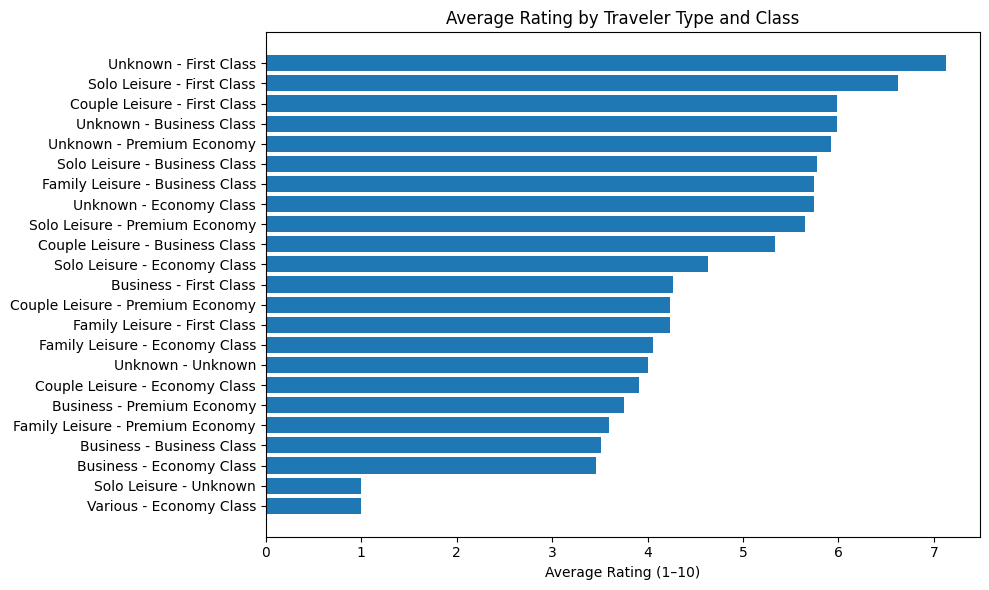

In [12]:
if trav_col is None:
    raise ValueError("Expected 'Traveler_Type' or 'Traveller_Type' in reviews.")

avg_rating = (reviews
              .groupby([trav_col, "Class"], dropna=False)["Rating"]
              .mean()
              .reset_index()
              .sort_values("Rating", ascending=False))

print("Top 5 traveler-type & class combos (avg rating):")
display(avg_rating.head(5))
print("\nBottom 5 combos:")
display(avg_rating.tail(5))

# Nice barh plot
labels = (avg_rating[trav_col].fillna("Unknown") + " - " +
          avg_rating["Class"].astype(str).fillna("Unknown"))
plt.figure(figsize=(10,6))
plt.barh(labels, avg_rating["Rating"])
plt.title("Average Rating by Traveler Type and Class")
plt.xlabel("Average Rating (1–10)")
plt.gca().invert_yaxis()
plt.tight_layout()  # ensures labels and titles don't overlap
plt.show()


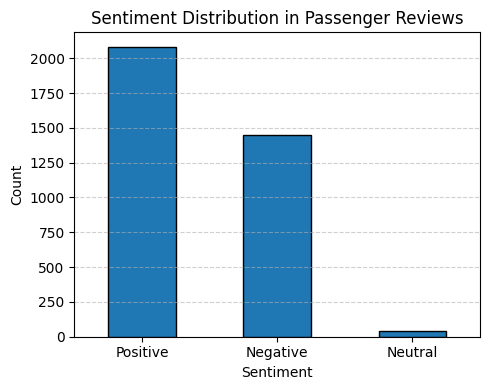

,Count
Sentiment_label,
Positive,2082
Negative,1452
Neutral,41


In [13]:
sent_counts = reviews["Sentiment_label"].value_counts(dropna=True)

plt.figure(figsize=(5,4))
sent_counts.plot(kind="bar", edgecolor="black")
plt.title("Sentiment Distribution in Passenger Reviews")
plt.xlabel("Sentiment"); plt.ylabel("Count"); plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()  # ensures labels and titles don't overlap
plt.show()

display(sent_counts.rename("Count").to_frame())


In [14]:
combo_stats = (reviews
  .groupby(['Traveller_Type','Class'])['Rating']
  .agg(mean='mean', n='count')
  .sort_values('mean', ascending=False))
combo_stats.to_csv("/kaggle/working/TravelerClass_Rating_withCounts.csv")
combo_stats.head(10), combo_stats.tail(10)


(                                    mean    n
 Traveller_Type Class                         
 Unknown        First Class      7.127273   55
 Solo Leisure   First Class      6.627907   43
 Couple Leisure First Class      5.983607   61
 Unknown        Business Class   5.982935  293
                Premium Economy  5.919540   87
 Solo Leisure   Business Class   5.780347  173
 Family Leisure Business Class   5.743902   82
 Unknown        Economy Class    5.740741  324
 Solo Leisure   Premium Economy  5.653061   98
 Couple Leisure Business Class   5.332335  334,
                                     mean    n
 Traveller_Type Class                         
 Family Leisure First Class      4.230769   13
                Economy Class    4.061069  262
 Unknown        Unknown          4.000000    1
 Couple Leisure Economy Class    3.908297  458
 Business       Premium Economy  3.750000   52
 Family Leisure Premium Economy  3.600000   25
 Business       Business Class   3.510791  278
            

In [15]:
sent_counts = reviews['Sentiment_label'].value_counts()
sent_pct = (sent_counts/sent_counts.sum()*100).round(1)
pd.concat([sent_counts.rename('count'), sent_pct.rename('percent')], axis=1)


,count,percent
Sentiment_label,,
Positive,2082,58.2
Negative,1452,40.6
Neutral,41,1.1


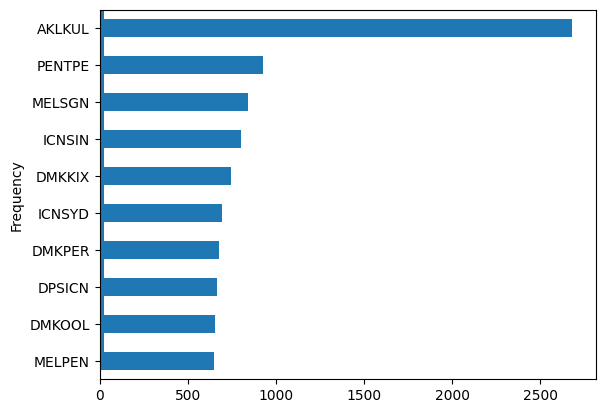

In [16]:
# re-make & save top routes figure
top_routes = bookings['route'].value_counts().head(10).sort_values(ascending=True)
ax = top_routes.plot(kind='barh'); ax.figure.savefig('/kaggle/working/top10_routes.png', dpi=200, bbox_inches='tight')

# save hour histogram
ax = bookings['flight_hour'].dropna().astype(int).plot(kind='hist', bins=24)
ax.figure.savefig('/kaggle/working/booking_hours_hist.png', dpi=200, bbox_inches='tight')

# save traveler×class averages
avg_rating.to_csv("/kaggle/working/TravelerType_Class_Ratings.csv", index=False)
